In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

type= <class 'numpy.ndarray'>  H:326 W:500


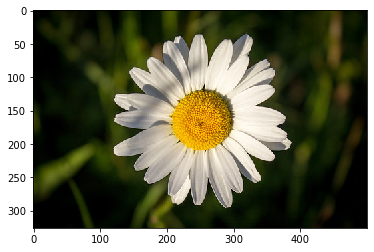

In [2]:
img = cv2.imread('ml100-03-final/image_data/train/daisy/0a3e7507742e246b3a2e630debbbaf99.jpg')
print('type=', type(img), ' H:%d W:%d'%((img.shape)[0], (img.shape)[1]))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images
images0 = load_images_from_folder('ml100-03-final/image_data/train/daisy')
images1 = load_images_from_folder('ml100-03-final/image_data/train/dandelion')
images2 = load_images_from_folder('ml100-03-final/image_data/train/rose')
images3 = load_images_from_folder('ml100-03-final/image_data/train/sunflower')
images4 = load_images_from_folder('ml100-03-final/image_data/train/tulip')
images_test = load_images_from_folder('ml100-03-final/image_data/test')

In [8]:
print(len(images0))
print(len(images1))
print(len(images2))
print(len(images3))
print(len(images4))
print(len(images_test))

500
687
515
488
633
2000


In [9]:
#蒐集所有的圖片，為了做資料前處理
img_all = []
for im in images0:
    img_all.append(im)
for im in images1:
    img_all.append(im)
for im in images2:
    img_all.append(im)
for im in images3:
    img_all.append(im)
for im in images4:
    img_all.append(im)
for im in images_test:
    img_all.append(im)

print(len(img_all))

4823


In [10]:
#計算所有圖片最小的寬與高
w_all = []
h_all = []
for im in img_all:
    h_all.append((im.shape)[0])
    w_all.append((im.shape)[1])

In [12]:
print(len(h_all))
print("w_all max = ", max(w_all))
print("w_all min = ", min(w_all))
print("h_all max = ", max(h_all))
print("h_all min = ", min(h_all))

4823
w_all max =  1024
w_all min =  134
h_all max =  855
h_all min =  80


In [ ]:
#圖片 SIZE 差太多了，需要縮放到相同SIZE
#先將大部分照片轉正，(扁)，方便之後縮放

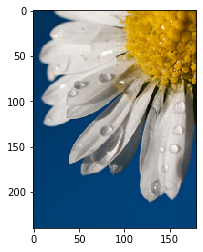

In [19]:
plt.imshow(cv2.cvtColor(img_all[12], cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
print(images[3].shape)

NameError: name 'images' is not defined